Questa per ora NON funziona
https://github.com/roshan-pandey/Semantic-Segmentation/blob/main/src/modelling.ipynb

In [49]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

In [2]:
sm.set_framework('tf.keras')

In [52]:
# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path, 0)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [53]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "original-dataset", "images")
masks_folder = os.path.join("..", "original-dataset", "masks")
n_classes = 5 # class for segmentation

image_dataset = data_loader(img_folder) # real images...
mask_dataset = data_loader(masks_folder) # masked images...
image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(image_dataset, axis = 3)
mask_dataset = np.array(mask_dataset)


In [54]:
print(image_dataset.shape)
print(mask_dataset.shape)
print(image_dataset[0].shape)
print(mask_dataset[0].shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

(211, 128, 128, 1)
(211, 128, 128)
(128, 128, 1)
(128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [60]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

array([0, 1, 2, 3, 4], dtype=int64)

In [61]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(211, 128, 128, 1)


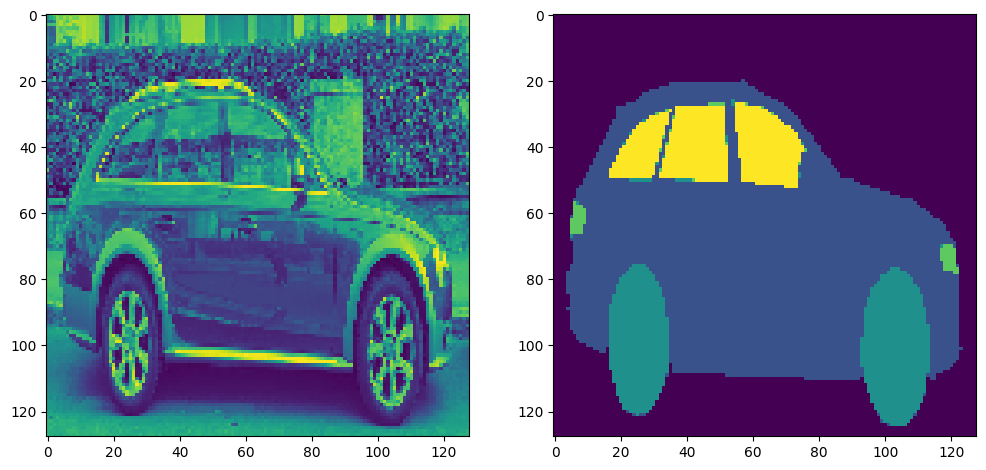

In [57]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [62]:
#Normalize images
image_dataset = image_dataset /255. 

#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
     

In [63]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train.shape)
print(y_train_cat.shape)

(168, 128, 128, 1)
(168, 128, 128, 5)


In [71]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)
print(X_train_prepr.shape)


(168, 128, 128, 1)


In [65]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=5, activation='softmax')
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

In [73]:
print(X_train_prepr.shape)
print(X_test_prepr.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(168, 128, 128, 1)
(43, 128, 128, 1)
(168, 128, 128, 5)
(43, 128, 128, 5)


In [69]:
# training the model for 100 epochs with batch size of 16...
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train_cat,
          batch_size=16, 
          epochs=10,
          verbose=1,
          callbacks=callbacks,
          validation_data=(X_test_prepr, y_test_cat))

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_7" "                 f"(type Functional).
    
    Input 0 of layer "bn_data" is incompatible with the layer: expected axis 3 of input shape to have value 3, but received input with shape (None, 128, 128, 1)
    
    Call arguments received by layer "model_7" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
      • training=True
      • mask=None
